In [2]:
import torch
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from tqdm.auto import tqdm
import numpy as np
from matplotlib import pyplot as plt
from torch import nn
import gin
from functools import partial
gin.enter_interactive_mode()

In [188]:
@gin.configurable
def get_xy(h=10, w=10, s=1000):
    res = np.zeros((s, h, w), dtype=np.float32)
    idxes_x = np.random.choice(h, s, replace=True)
    idxes_y = np.random.choice(w, s, replace=True)
    res[np.arange(s), idxes_x, idxes_y] = 1.0
    
    return res, (idxes_x, idxes_y)

In [189]:
h, w, s = 10, 10, 1000
gin.bind_parameter('get_xy.h', h)
gin.bind_parameter('get_xy.w', w)
gin.bind_parameter('get_xy.s', s)

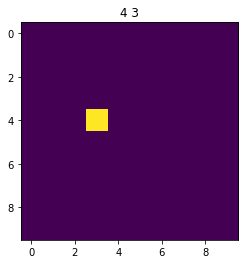

In [190]:
X, (xs, ys) = get_xy()

idx = np.random.choice(s)

plt.title(f"{xs[idx]} {ys[idx]}")
plt.imshow(X[idx])

In [316]:
act_cls = lambda **kwargs: nn.Tanh()


from sparse_causal_model_learner_rl.trainable.quadratic_neuron import Quadratic
from sparse_causal_model_learner_rl.trainable.poly_activation import PolyAct
        
act_cls = partial(PolyAct, orig_act_cls=lambda: (lambda x: x)) # nn.Tanh
# layer_cls = nn.Linear
layer_cls = Quadratic

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
#         self.fc1 = layer_cls(in_features=h * w, out_features=10)
#         self.fc2 = layer_cls(in_features=10, out_features=4)
        self.fc = nn.Linear(in_features=h*w, out_features=4)
#         self.act = act_cls(features=10)#nn.Tanh()
    def forward(self, x):
        x = x.flatten(start_dim=1)
#         x = self.act(self.fc1(x))
#         x = self.fc2(x)
        x = self.fc(x)
        return x

class Reconstructor(nn.Module):
    def __init__(self):
        super(Reconstructor, self).__init__()
        self.fc1 = layer_cls(in_features=4, out_features=10 * h * w)
        self.fc2 = nn.Linear(in_features=10 * h * w, out_features=h * w)
        self.act1 = act_cls(features=10*h*w)#nn.Tanh()
        self.act2 = act_cls(features=h*w)
    def forward(self, x):
        x = self.act1(self.fc1(x))
        x = self.act2(self.fc2(x))
        x = x.view(x.shape[0], h, w)
        return x

True

In [239]:
out_manual

tensor([[-0.9184,  0.9588,  0.7668,  2.2555, -0.0493,  0.8370],
        [-0.9184,  0.9588,  0.7668,  2.2555, -0.0493,  0.8370],
        [-0.9184,  0.9588,  0.7668,  2.2555, -0.0493,  0.8370],
        [-0.9184,  0.9588,  0.7668,  2.2555, -0.0493,  0.8370],
        [-0.9184,  0.9588,  0.7668,  2.2555, -0.0493,  0.8370],
        [-0.9184,  0.9588,  0.7668,  2.2555, -0.0493,  0.8370],
        [-0.9184,  0.9588,  0.7668,  2.2555, -0.0493,  0.8370],
        [-0.9184,  0.9588,  0.7668,  2.2555, -0.0493,  0.8370],
        [-0.9184,  0.9588,  0.7668,  2.2555, -0.0493,  0.8370],
        [-0.9184,  0.9588,  0.7668,  2.2555, -0.0493,  0.8370],
        [-0.9184,  0.9588,  0.7668,  2.2555, -0.0493,  0.8370],
        [-0.9184,  0.9588,  0.7668,  2.2555, -0.0493,  0.8370],
        [-0.9184,  0.9588,  0.7668,  2.2555, -0.0493,  0.8370],
        [-0.9184,  0.9588,  0.7668,  2.2555, -0.0493,  0.8370],
        [-0.9184,  0.9588,  0.7668,  2.2555, -0.0493,  0.8370],
        [-0.9184,  0.9588,  0.7668,  2.2

In [219]:
rec = Reconstructor()
dec = Decoder()

In [193]:
rec.act1.a

Parameter containing:
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [0.0010, 0.0010, 0.0010,  ..., 0.0010, 0.0010, 0.0010],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       requires_grad=True)

In [194]:
data = torch.from_numpy(X)

In [195]:
def loss():
#     softmaxed = torch.nn.Softmax(1)(rec(dec(data)).flatten(start_dim=1))
#     answers = torch.argmax(data.flatten(start_dim=1), dim=1)
    
#     ce = torch.nn.CrossEntropyLoss()
#     loss = ce(softmaxed, answers)
   
#     delta = (rec(dec(data)) - data).flatten(start_dim=1)
#     std = data.std(0, keepdim=True).flatten(start_dim=1)
#     std = torch.where(std < 1e-6, torch.ones_like(std), std)
#     delta = delta.pow(2)
#     delta = delta / std.pow(2)
#     loss = delta.sum(1).mean(0)
    delta = (rec(dec(data)) - data).flatten(start_dim=1)
    loss = delta.pow(2).sum(1).mean(0)
    return loss

In [196]:
opt = torch.optim.Adam(list(rec.parameters()) + list(dec.parameters()),
                       lr=1e-3)

In [197]:
losses = []

In [198]:
for i in tqdm(range(10000)):
    if i % 10 == 0:
        X, (xs, ys) = get_xy()
        data = torch.from_numpy(X)
    
    opt.zero_grad()
    l = loss()
    l.backward()
    opt.step()
    losses.append(l.item())

KeyboardInterrupt: 

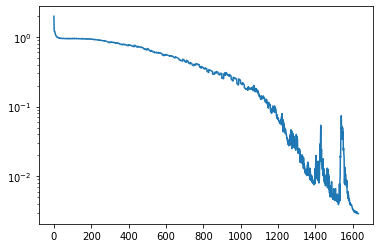

In [199]:
plt.plot(losses)
plt.yscale('log')

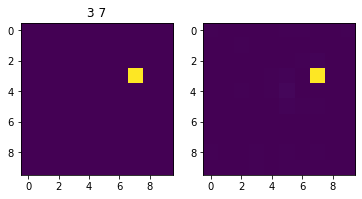

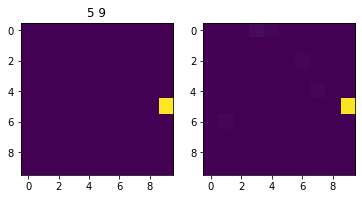

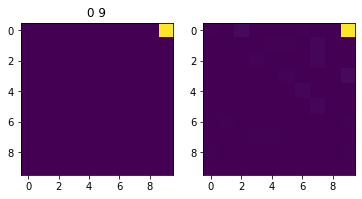

In [200]:
X, (xs, ys) = get_xy()
data = torch.from_numpy(X)

Xrec = rec(dec(data))
for _ in range(3):
    idx = np.random.choice(s)

    plt.subplot(1, 2, 1)
    plt.title(f"{xs[idx]} {ys[idx]}")
    plt.imshow(X[idx])
    plt.subplot(1, 2, 2)
    xrecnp = Xrec.detach().cpu().numpy()[idx]
    plt.imshow(xrecnp, vmin=0, vmax=1)# >= np.max(xrecnp))
    plt.show()

In [201]:
plt.imshow

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, *, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

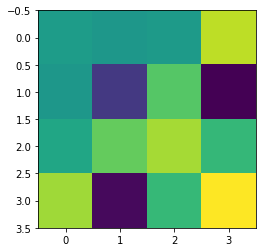

In [202]:
plt.imshow(rec.fc1.W[7, :, :].detach().numpy())

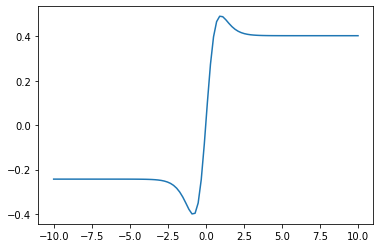

In [217]:
xs = np.linspace(-10, 10, 100)
idx = 40
xs_ = np.tanh(xs)
pows = [np.power(xs_, i) for i in range(4)]
xs_pows = rec.act1.a[:, idx:idx+1].detach().cpu().numpy() * np.array(pows)
plt.plot(xs, np.sum(xs_pows, axis=0))